You work at a SARS-CoV-2 PCR test center and your expensive qPCR machine has broken. But the school kids in your town urgently need their test results in order to participate safely in the big Nicolaus performance they have been preparing for all year. Luckily, your team also has a colorimetric dye - it changes color depending on DNA concentration - and all the reagents required to perform an alternative reaction to PCR called LAMP. In terms of equipment, all you need is a heating block. Luckily, you have one which is functional. A LAMP reaction requires only that the temperature required for the reaction is held constant. (Typically this is about 65 degrees C.) You reason that if you can implement a reliable readout for colorimetric LAMP, you will be able to run the tests using LAMP and allow the kids to safely participate in their performance.

LAMP works similarly to PCR in that, if a particular sample is "positive", the reaction was able to amplify DNA because the LAMP primers matched a complementary sequence in the sample, and thus the LAMP reaction could generate large amounts of amplified product DNA. When using a colorimetric dye, the color changes from the "negative color" indicating low DNA concentration to the "positive color" indicating high DNA concentration. Here we use a dye from the NEB Colorimetric WarmStart LAMP Kit which is yellow when positive and red when negative. (Other colorimetric dyes such as Hydroxy Naphthol Blue - HNB - also are available and may have different colors.)

To implement the reliable readout, you decide to implement a computer vision program that eliminates the need for subjective color judgement and potential errors by colorblind technicians. Based on what you have learned in a bioinformatics class, you have decided to perform "color quantization" on images acquired with a mobile phone camera to then turn full-color images into a single binarized image showing the locations of the wells with positive samples.

In this exercise, we use an image from [this preprint](https://www.medrxiv.org/content/10.1101/2020.05.05.20092288v1) which was later published as [this paper](https://stm.sciencemag.org/content/12/556/eabc7075/tab-article-info).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import scipy.misc
from scipy import ndimage
import imageio

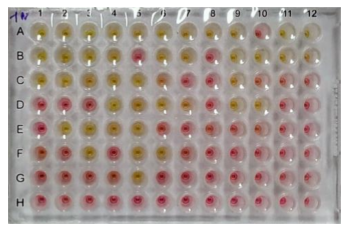

In [2]:
im_rgb = imageio.imread('RT-LAMP-Dao-Thi-2020-plate.png')
# Image CC-BY-ND 4.0 International license, copyright the authors of Dao Thi et al. (2020)
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(im_rgb);

In [3]:
im_rgb.shape

(318, 488, 3)

In [4]:
data = im_rgb / 255.0 # use 0...1 scale
data = data.reshape(318 * 488, 3)
data.shape

(155184, 3)

In [5]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)
    return ax

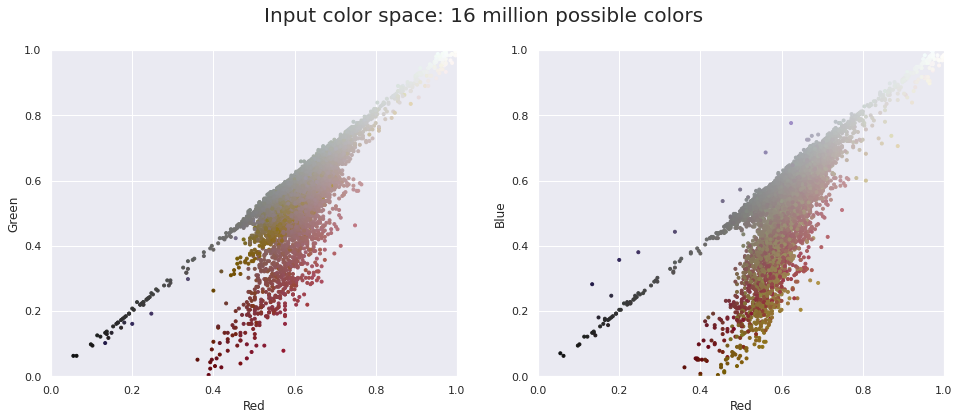

In [6]:
plot_pixels(data, title='Input color space: 16 million possible colors');

# Q1 Determine a value of *k*, the number of clusters, that enables a "good" clustering of the colors which will be useful in creating a reliable program.

You will probably want to test several values of `k` and use the one that works best for your task.

In [7]:
k=8

In [8]:
# test that k is an integer
assert k==k-0

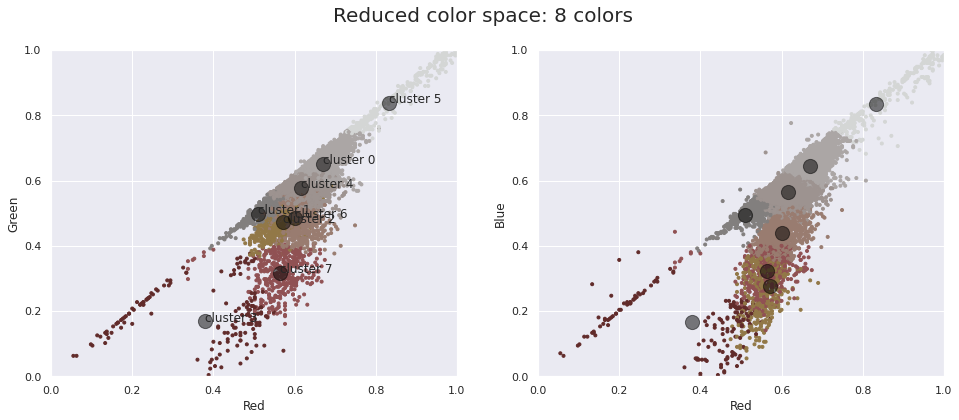

In [9]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(k, random_state=0)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

ax = plot_pixels(data, colors=new_colors,
            title=f"Reduced color space: {k} colors")

centers = kmeans.cluster_centers_
ax[0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
for i in range(k):
    ax[0].text( centers[i, 0], centers[i, 1], f"cluster {i}")


ax[1].scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);

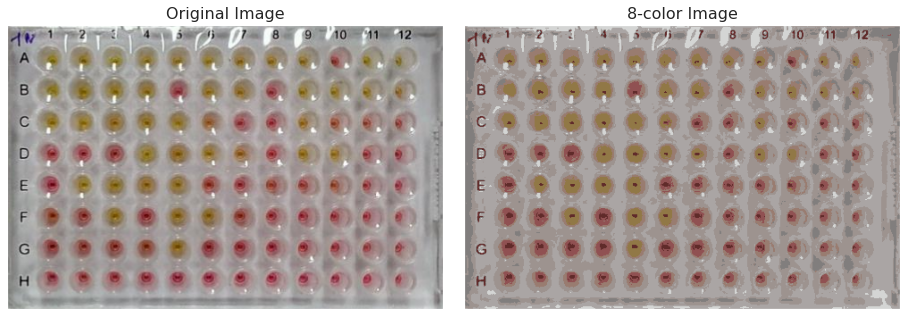

In [10]:
# Let's plot the original image side-by-side with the color quantized image.

im_rgb_recolored = new_colors.reshape(im_rgb.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(im_rgb)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(im_rgb_recolored)
ax[1].set_title(f'{k}-color Image', size=16);

In [11]:
y_kmeans = kmeans.predict(data)

In [12]:
np.unique(y_kmeans)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [13]:
y_kmeans.shape

(155184,)

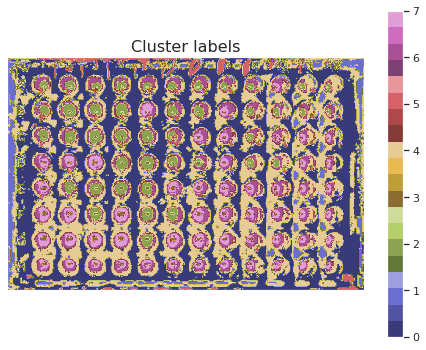

In [14]:
labels = y_kmeans.copy()
labels.shape = 318, 488

fig, ax = plt.subplots(1, 1, figsize=(8, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

cax = ax.imshow(labels, cmap="tab20b")
ax.set_title('Cluster labels', size=16)
fig.colorbar(cax);

# Q2 Determine which cluster ID (the label of the cluster) best detects the positive sample wells.

Set this to the variable `best_cluster_id`.

In [15]:
best_cluster_id=2

In [16]:
# test that the answer is an integer.
assert best_cluster_id == best_cluster_id-0

In [17]:
condition = y_kmeans == best_cluster_id

In [18]:
binary = condition.copy()
binary.shape = 318, 488

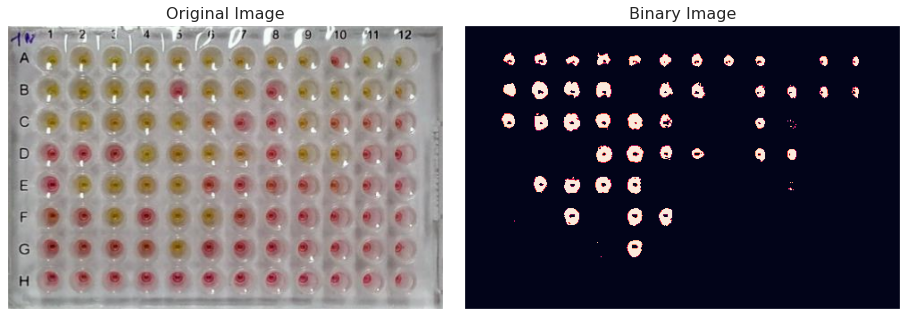

In [19]:
im_rgb_recolored = new_colors.reshape(im_rgb.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(im_rgb)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(binary)
ax[1].set_title(f'Binary Image', size=16);

## Further thoughts

- LAMP is a potentially viable alternative to qPCR tests which would be much less expensive to implement. In fact, various efforts are underway to make LAMP-based SARS-CoV-2 testing a reality. See, e.g. [RTLAMP.org](https://www.rtlamp.org/), [Corona Detective: a simple, scalable, and robust SARS-CoV-2 detection method based on reverse transcription loop-mediated isothermal amplification](https://abrf.memberclicks.net/assets/JBT/September_2021_Early_Access/Corona%20Detective%20a%20simple%2C%20scalable%2C%20and%20robust%20SARS-CoV-2%20detection%20method%20based%20on.pdf), and many more.

- How would you automatically determine the well number (e.g. "A1" or "F3") and the status of the result ("positive" or "negative") in a continuation of the above exercise?

- The kids thank you for allowing their Nicolaus performance to happen safely!